In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
%matplotlib inline

# Preprocessing for Physician Notes

### Regex for filtering based on Descriptions

In [2]:
descriptions = pd.read_csv("List of Physician Descriptions.csv")
descriptions = list(descriptions.iloc[:,0])

In [3]:
#Regex extraction for note types
adm = [x for x in descriptions if re.search(r"adm", x.lower())]
prog = [x for x in descriptions if re.search(r"prog", x.lower())]
icu = [x for x in descriptions if re.search(r"icu", x.lower())]

In [5]:
for i in [adm, prog, icu]:
    print(len(i)/len(descriptions))

0.2403846153846154
0.2620192307692308
0.36778846153846156


In [5]:
#Writing tables out
pd.DataFrame(adm).to_csv("adm.csv", index = False)
pd.DataFrame(prog).to_csv("prog.csv", index = False)
pd.DataFrame(icu).to_csv("icu.csv", index = False)

In [6]:
admissions = pd.read_csv("admissions_notes.csv")
admissions.head(2)

,ROW_ID,SUBJECT_ID,HADM_ID,CHARTDATE,CHARTTIME,STORETIME,CATEGORY,DESCRIPTION,CGID,ISERROR,TEXT,descriptions
0,16106,29075,179159.0,2116-02-06,2116-02-06 00:25:00,2116-02-06 02:40:50,Physician,Physician Resident Admission Note,16198,NaN,Chief Complaint: GI bleeding\r\n HPI:\r\n ...,Physician Resident Admission Note
1,16107,29075,179159.0,2116-02-06,2116-02-06 00:25:00,2116-02-06 02:50:40,Physician,Physician Resident Admission Note,16198,NaN,Chief Complaint: GI bleeding\r\n HPI:\r\n ...,Physician Resident Admission Note


# Preprocessing for Diagnosis Table

In [4]:
diagnosis = pd.read_csv("diagnosis.csv")

# Creating variable for total visits
from collections import defaultdict
temp = defaultdict(lambda: 0)

for i in diagnosis["SUBJECT_ID"]:
    temp[i] += 1

temp = pd.DataFrame(pd.Series(temp)).reset_index()
temp.rename(columns = {"index": "SUBJECT_ID"}, inplace = True)

diagnosis = diagnosis.merge(temp, on = "SUBJECT_ID", how = "left")
diagnosis.rename(columns = {0: "Total Visits"}, inplace = True)

# Creating dummy varaible for multiple visits
diagnosis["Multiple Visits"] = diagnosis["Total Visits"].apply(lambda x: False if x == 1 else True)
diagnosis.drop(labels = 13518, axis = 0, inplace = True)
diagnosis["ROW_ID"] = diagnosis["ROW_ID"].astype(int)

[(-1, 10)]

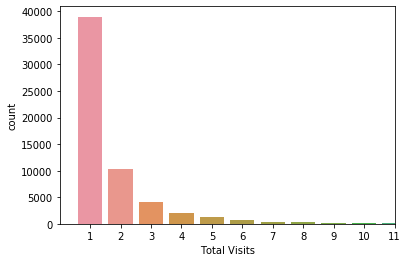

In [8]:
g = sns.countplot(diagnosis["Total Visits"])
g.set(xlim=(-1,10))

Text(0.5, 1.0, 'Class Size for All Patients')

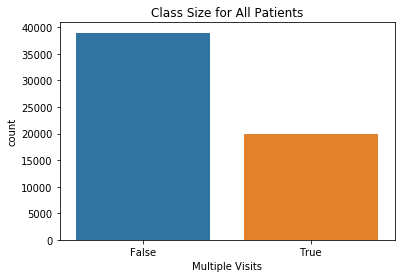

In [9]:
g = sns.countplot(x = diagnosis["Multiple Visits"])
g.set_title("Class Size for All Patients")

In [10]:
diagnosis.to_csv("diagnosis_with_visits.csv")

### Filtering and creating mental health table with ICD9 codes(granularity = patient level)

In [5]:
sample = list(np.arange(2900,3200, 1))
sample = [str(x) for x in sample]
mental = diagnosis[diagnosis["ICD9_CODE"].astype(str).isin(sample)]
mental = mental.groupby(["SUBJECT_ID"]).last().reset_index()
mental.head(5)

,SUBJECT_ID,ROW_ID,HADM_ID,ICD9_CODE,SHORT_TITLE,LONG_TITLE,Total Visits,Multiple Visits
0,45,73,157907,3051,Tobacco use disorder,Tobacco use disorder,1,False
1,63,2,195961,3079,Special symptom NEC/NOS,Other and unspecified special symptoms or synd...,1,False
2,114,501,178393,3051,Tobacco use disorder,Tobacco use disorder,1,False
3,123,574,195632,3051,Tobacco use disorder,Tobacco use disorder,1,False
4,132,686,160192,3051,Tobacco use disorder,Tobacco use disorder,1,False


Text(0.5, 1.0, 'Class Size for Psychiatric Patients')

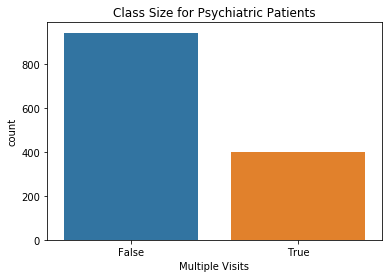

In [12]:
g = sns.countplot(mental["Multiple Visits"])
g.set_title("Class Size for Psychiatric Patients")

Text(0.5, 1.0, 'Top Mental Disorders')

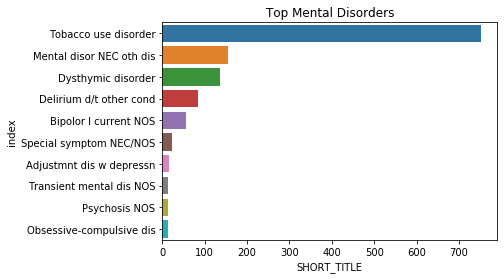

In [13]:
top = pd.DataFrame(mental["SHORT_TITLE"].value_counts().head(10)).reset_index()
g = sns.barplot(x = "SHORT_TITLE", y = "index", data = top)
g.set_title("Top Mental Disorders")

### Removing Tobacco use and adding new ICD codes

In [6]:
selfharmcodes = ["E" + str(x) for x in np.arange(9500, 9600, 1)]
selfharmpatients = diagnosis[diagnosis["ICD9_CODE"].isin(selfharmcodes)]
len(selfharmpatients)

78

In [7]:
#Creating list of ICD9 codes for drug abuse

drugcodes = pd.read_excel("drugcodes.xlsx", header = None)
drugcodes.rename(columns = {0: "Codes", 1: "Title"}, inplace = True)
drugcodes = list(drugcodes["Codes"])
drugcodes = [re.sub(r'\.', '', str(x)) for x in drugcodes]
drugcodes = [x + "0" if len(x) == 3 else x for x in drugcodes]
drugpatients = diagnosis[diagnosis["ICD9_CODE"].isin(drugcodes)]
len(drugpatients)

312

In [8]:
sample = list(np.arange(2900,3200, 1))
sample = [str(x) for x in sample]
sample.remove("3051")
mentalpatients = diagnosis[diagnosis["ICD9_CODE"].isin(sample)]
len(mentalpatients)

619

In [9]:
len(set(mentalpatients["SUBJECT_ID"])-set(selfharmpatients["SUBJECT_ID"]))

597

In [10]:
totalpatients = list(selfharmpatients["SUBJECT_ID"])
totalpatients.extend(x for x in list(drugpatients["SUBJECT_ID"]) if x not in totalpatients)
totalpatients.extend(x for x in list(mentalpatients["SUBJECT_ID"]) if x not in totalpatients)
len(totalpatients)

970

# Preprocessing for Discharge Summary


In [2]:
discharge = pd.read_csv("discharge.csv")
discharge["TEXT"] = discharge["TEXT"].astype(str)
discharge.head(2)

,ROW_ID,SUBJECT_ID,HADM_ID,CHARTDATE,CHARTTIME,STORETIME,CATEGORY,DESCRIPTION,CGID,ISERROR,TEXT
0,74.0,22532,167853,2151-08-04,NaN,NaN,Discharge summary,Report,NaN,NaN,Admission Date: [**2151-7-16**] Dischar...
1,75.0,13702,107527,2118-06-14,NaN,NaN,Discharge summary,Report,NaN,NaN,Admission Date: [**2118-6-2**] Discharg...


In [14]:
discharge["DESCRIPTION"].value_counts()

Report      55177
Addendum     4475
Name: DESCRIPTION, dtype: int64

In [12]:
# Keeping only report data
discharge = discharge[discharge["DESCRIPTION"] == "Report"]
discharge["TEXT"] = discharge["TEXT"].apply(lambda x: re.sub(r'\r\n', " ", str(x)))
discharge = discharge.reset_index(drop = True)

In [4]:
discharge["TEXT"][2]

'Admission Date:  [**2119-5-4**]              Discharge Date:   [**2119-5-25**]\r\n\r\n\r\nService: CARDIOTHORACIC\r\n\r\nAllergies:\r\nAmlodipine\r\n\r\nAttending:[**Last Name (NamePattern1) 1561**]\r\nChief Complaint:\r\n81 yo F smoker w/ COPD, severe TBM, s/p tracheobronchoplasty [**5-5**]\r\ns/p perc trach [**5-13**]\r\n\r\nMajor Surgical or Invasive Procedure:\r\nbronchoscopy 3/31,4/2,3,[**6-12**], [**5-17**], [**5-19**]\r\ns/p trachealplasty [**5-5**]\r\npercutaneous tracheostomy [**5-13**] after failed extubation\r\ndown size trach on [**5-25**] to size 6 cuffless\r\n\r\n\r\nHistory of Present Illness:\r\nThis 81 year old woman has a history of COPD. Over the past five\r\n\r\nyears she has had progressive difficulties with her breathing.\r\nIn\r\n[**2118-6-4**] she was admitted to [**Hospital1 18**] for respiratory failure\r\ndue\r\nto a COPD exacerbation. Due to persistent hypoxemia, she\r\nrequired\r\nintubation and a eventual bronchoscopy on [**2118-6-9**] revealed marked\r\n

# Creating Final Joined Table

In [13]:
#Joining previously created two tables
filtered_discharge = discharge[discharge["SUBJECT_ID"].isin(totalpatients)].groupby(["SUBJECT_ID"]).first().reset_index()
filtered_diagnosis = diagnosis.groupby(["SUBJECT_ID"]).first().reset_index().drop(columns = ["ROW_ID", "HADM_ID"])
df = filtered_discharge.merge(filtered_diagnosis, on = "SUBJECT_ID", how = "left")

# Creating history of present illness column
temp = df["TEXT"].apply(lambda x: re.search(r'history of present illness:.*?:', x.lower()))
df = df.iloc[temp.dropna().index]
df["hopi"] = df["TEXT"].apply(lambda x: re.findall(r'history of present illness:.*?:', x.lower())[0].rsplit(" ", 3)[0])
df["hopi"] = [x.split(":")[1] if len(x.split(":")) == 2 else x for x in df["hopi"]]
df = df.reset_index(drop = True)
df.head(2)

# Creating column with all text
df["full_text"] = df["TEXT"].apply(lambda x: re.findall(r'history of present illness:.*?:', x.lower())[0])

#Creating column of discharge instructions
df["discharge_diagnosis_instructions"] = df["TEXT"].apply(lambda x: re.findall(r'discharge diagnosis.*', x.lower()))
df["discharge_diagnosis_instructions"] = [x[0] if len(x) > 0 else "None" for x in df["discharge_diagnosis_instructions"]]

# Recoding Multiple Visits Columns
df["Multiple Visits"] = [1 if x == True else 0 for x in df["Multiple Visits"]]

df.head(2)

,SUBJECT_ID,ROW_ID,HADM_ID,CHARTDATE,CHARTTIME,STORETIME,CATEGORY,DESCRIPTION,CGID,ISERROR,TEXT,ICD9_CODE,SHORT_TITLE,LONG_TITLE,Total Visits,Multiple Visits,hopi,full_text,discharge_diagnosis_instructions
0,63,4347.0,195961,2169-01-07,NaN,NaN,Discharge summary,Report,NaN,NaN,Admission Date: [**2169-1-7**] D...,3079,Special symptom NEC/NOS,Other and unspecified special symptoms or synd...,1,0,"this is a 88 year-old man with dementia, copd...",history of present illness: this is a 88 year-...,discharge diagnosis: primary: fall secondary:...
1,78,787.0,100536,2177-02-17,NaN,NaN,Discharge summary,Report,NaN,NaN,Admission Date: [**2177-2-14**] Dischar...,E8532,Acc poisn-benzdiaz tranq,Accidental poisoning by benzodiazepine-based t...,1,0,this is a 48-year-old hiv positive african-a...,history of present illness: this is a 48-year...,None


In [14]:
df.to_csv("final.csv")

Text(0.5, 1.0, 'Class Count for Final DataFrame')

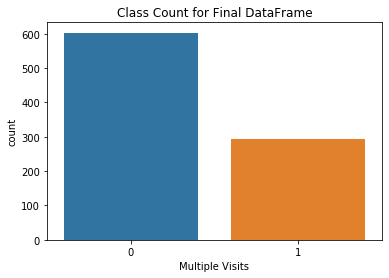

In [23]:
g = sns.countplot(df["Multiple Visits"])
g.set_title("Class Count for Final DataFrame")

In [24]:
len(df[df["Multiple Visits"] == 0])/len(df)

0.6729910714285714

# Modeling with LSTM (using history of past illness)

In [2]:
import nltk
from nltk.corpus import stopwords

from numpy import array
from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers.core import Activation, Dropout, Dense
from keras.layers import Flatten
from keras.layers import GlobalMaxPooling1D
from keras.layers import LSTM
from keras.layers.embeddings import Embedding
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from numpy import array
from numpy import asarray
from numpy import zeros
from gensim import utils
import gensim.parsing.preprocessing as gsp


Using TensorFlow backend.


### Preprocessing for model input

In [18]:
filters = [
           gsp.strip_punctuation,
           gsp.remove_stopwords, 
           gsp.stem_text
          ]

def clean_text(s):
    s = s.lower()
    s = utils.to_unicode(s)
    for f in filters:
        s = f(s)
    return s

df["hopi"] = df["hopi"].apply(clean_text)
df["full_text"] = df["full_text"].apply(clean_text)
df["discharge_diagnosis_instructions"] = df["discharge_diagnosis_instructions"].apply(clean_text)

### Creating embeddings

In [27]:
#Creating training and test
X_train, X_test, y_train, y_test = train_test_split(df["hopi"], df["Multiple Visits"], test_size = 0.3, random_state = 42)

#Tokenize inputs
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)
X_train =tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

#Padding for same input length
vocab_size = len(tokenizer.word_index) + 1
# maxlen = max([len(x) for x in X_train])
maxlen = 150

X_train = pad_sequences(X_train, padding = "post", maxlen = maxlen)
X_test = pad_sequences(X_test, padding = "post", maxlen = maxlen)

# Reading in GloVe embeddings
embeddings_dictionary = dict()
glove_file = open('glove.6B.100d.txt', encoding="utf8")

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = asarray(records[1:], dtype='float32')
    embeddings_dictionary [word] = vector_dimensions
glove_file.close()

# Creating embedding matrix with our words
embedding_matrix = zeros((vocab_size, 100))
for word, index in tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

### Creating LSTM network

In [28]:
model = Sequential()
embedding_layer = Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=maxlen , trainable=False)
model.add(embedding_layer)
model.add(LSTM(63, dropout_W = 0.3, dropout_U = 0.3))

model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

print(model.summary())

C:\Users\Kevin\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(63, dropout=0.3, recurrent_dropout=0.3)`
  after removing the cwd from sys.path.


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 150, 100)          583000    
_________________________________________________________________
lstm_1 (LSTM)                (None, 63)                41328     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 64        
Total params: 624,392
Trainable params: 41,392
Non-trainable params: 583,000
_________________________________________________________________
None


### Training LSTM

In [29]:
history = model.fit(X_train, y_train, batch_size=60, epochs=50, verbose=0, validation_split=0.3, class_weight={0: 0.8, 1: 1})

score = model.evaluate(X_test, y_test, verbose=1)

269/269 [==============================] - 0s 825us/step


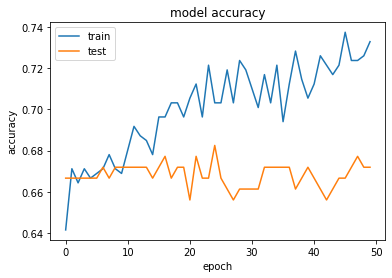

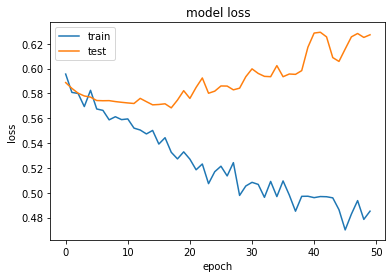

In [30]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

In [31]:
score

[0.7660644201762614, 0.6579925417900085]

#  Modelling with LSTM using full discharge summary

In [32]:
#Creating training and test
X_train, X_test, y_train, y_test = train_test_split(df["full_text"], df["Multiple Visits"], test_size = 0.3, random_state = 42)

#Tokenize inputs
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)
X_train =tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

#Padding for same input length
vocab_size = len(tokenizer.word_index) + 1
# maxlen = max([len(x) for x in X_train])
maxlen = 350

X_train = pad_sequences(X_train, padding = "post", maxlen = maxlen)
X_test = pad_sequences(X_test, padding = "post", maxlen = maxlen)

# Reading in GloVe embeddings
embeddings_dictionary = dict()
glove_file = open('glove.6B.100d.txt', encoding="utf8")

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = asarray(records[1:], dtype='float32')
    embeddings_dictionary [word] = vector_dimensions
glove_file.close()

# Creating embedding matrix with our words
embedding_matrix = zeros((vocab_size, 100))
for word, index in tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

In [33]:
model = Sequential()
embedding_layer = Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=maxlen , trainable=False)
model.add(embedding_layer)
model.add(LSTM(128, dropout_W = 0.3, dropout_U = 0.3))

model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

print(model.summary())

C:\Users\Kevin\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(128, dropout=0.3, recurrent_dropout=0.3)`
  after removing the cwd from sys.path.


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 350, 100)          584100    
_________________________________________________________________
lstm_2 (LSTM)                (None, 128)               117248    
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 129       
Total params: 701,477
Trainable params: 117,377
Non-trainable params: 584,100
_________________________________________________________________
None


In [34]:
history = model.fit(X_train, y_train, batch_size=80, epochs=50, verbose=0, validation_split=0.3, class_weight = {0:0.7, 1:1})
score = model.evaluate(X_test, y_test, verbose=1)

269/269 [==============================] - 0s 2ms/step


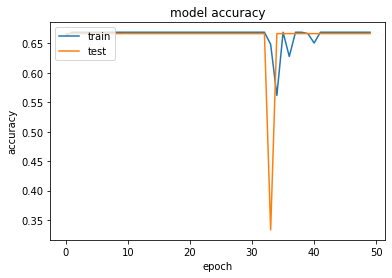

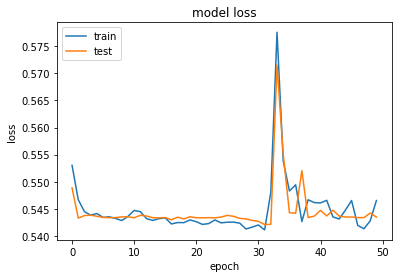

In [35]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

# Modeling with LSTM using Discharge Instructions

In [36]:
#Creating training and test
X_train, X_test, y_train, y_test = train_test_split(df["discharge_diagnosis_instructions"], df["Multiple Visits"], test_size = 0.3, random_state = 42)

#Tokenize inputs
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)
X_train =tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

#Padding for same input length
vocab_size = len(tokenizer.word_index) + 1
# maxlen = max([len(x) for x in X_train])
# maxlen = 350
maxlen = 150

X_train = pad_sequences(X_train, padding = "post", maxlen = maxlen)
X_test = pad_sequences(X_test, padding = "post", maxlen = maxlen)

# Reading in GloVe embeddings
embeddings_dictionary = dict()
glove_file = open('glove.6B.100d.txt', encoding="utf8")

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = asarray(records[1:], dtype='float32')
    embeddings_dictionary [word] = vector_dimensions
glove_file.close()

# Creating embedding matrix with our words
embedding_matrix = zeros((vocab_size, 100))
for word, index in tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

In [37]:
model = Sequential()
embedding_layer = Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=maxlen , trainable=False)
model.add(embedding_layer)
model.add(LSTM(60, dropout_W = 0.3, dropout_U = 0.3))

model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

print(model.summary())

C:\Users\Kevin\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(60, dropout=0.3, recurrent_dropout=0.3)`
  after removing the cwd from sys.path.


Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 150, 100)          512600    
_________________________________________________________________
lstm_3 (LSTM)                (None, 60)                38640     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 61        
Total params: 551,301
Trainable params: 38,701
Non-trainable params: 512,600
_________________________________________________________________
None


In [38]:
history = model.fit(X_train, y_train, batch_size=80, epochs=50, verbose=0, validation_split=0.3)
score = model.evaluate(X_test, y_test, verbose=1)

269/269 [==============================] - 0s 852us/step


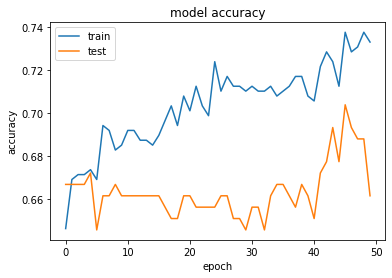

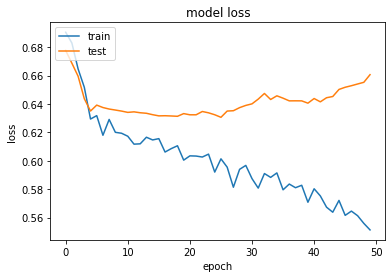

In [39]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

# Modeling with BERT

### Setting up TensorFlow

In [2]:
df = pd.read_csv("final.csv")

In [3]:
import tensorflow as tf

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [4]:
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from pytorch_pretrained_bert import BertTokenizer, BertConfig
from pytorch_pretrained_bert import BertAdam, BertForSequenceClassification
from tqdm import tqdm, trange
import pandas as pd
import io
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn

Using TensorFlow backend.


In [5]:
# set GPU
# device = torch.device("cuda")
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()
torch.cuda.get_device_name(0)

'Tesla V100-SXM2-16GB'

### Preprocessing data and setting up BERT

In [21]:
# Recreating original, unprocessed text columns
temp = df["TEXT"].apply(lambda x: re.search(r'history of present illness:.*?:', x.lower()))
df = df.iloc[temp.dropna().index]
df["hopi"] = df["TEXT"].apply(lambda x: re.findall(r'history of present illness:.*?:', x.lower())[0].rsplit(" ", 3)[0])
df["hopi"] = [x.split(":")[1] if len(x.split(":")) == 2 else x for x in df["hopi"]]
df = df.reset_index(drop = True)

df["discharge_diagnosis_instructions"] = df["TEXT"].apply(lambda x: re.findall(r'discharge diagnosis.*', x.lower()))
df["discharge_diagnosis_instructions"] = [x[0] if len(x) > 0 else "None" for x in df["discharge_diagnosis_instructions"]]

# Adding BERT tags
df["hopi_bert"] = ["[CLS] " + query + " [SEP]" for query in df["hopi"]]

# Tokenizing
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
tokenized_texts = [tokenizer.tokenize(sent) for sent in df["hopi_bert"]]

tokenized_texts = [x[0:500] if len(x) >= 500 else x for x in tokenized_texts]

# Padding tokens and setting ids
input_ids = pad_sequences([tokenizer.convert_tokens_to_ids(txt) for txt in tokenized_texts],
                          maxlen=500, dtype="long", truncating="post", padding="post")


# Create attention masks
attention_masks = []

for seq in input_ids:
  seq_mask = [float(i>0) for i in seq]
  attention_masks.append(seq_mask)


### Creating training/test data

In [22]:
# Use train_test_split to split our data into train and validation sets for training
train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(input_ids, df["Multiple Visits"].astype("category"), 
                                                            random_state=42, test_size=0.3)
train_masks, validation_masks, _, _ = train_test_split(attention_masks, input_ids,
                                             random_state=42, test_size=0.3)
                                             
# Converting into tensors
train_inputs = torch.tensor(train_inputs).long()
validation_inputs = torch.tensor(validation_inputs).long()
train_labels = torch.tensor(train_labels.values).long()
validation_labels = torch.tensor(validation_labels.values).long()
train_masks = torch.tensor(train_masks).long()
validation_masks = torch.tensor(validation_masks).long()

# Batch Size 
batch_size = 30

# Setting up DataLoader
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)
validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)


### Training BERT

In [23]:
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)

if torch.cuda.device_count() > 1:
  model = nn.DataParallel(model)
else:
    print("Error")

model.to(device)

DataParallel(
  (module): BertForSequenceClassification(
    (bert): BertModel(
      (embeddings): BertEmbeddings(
        (word_embeddings): Embedding(30522, 768, padding_idx=0)
        (position_embeddings): Embedding(512, 768)
        (token_type_embeddings): Embedding(2, 768)
        (LayerNorm): BertLayerNorm()
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (encoder): BertEncoder(
        (layer): ModuleList(
          (0): BertLayer(
            (attention): BertAttention(
              (self): BertSelfAttention(
                (query): Linear(in_features=768, out_features=768, bias=True)
                (key): Linear(in_features=768, out_features=768, bias=True)
                (value): Linear(in_features=768, out_features=768, bias=True)
                (dropout): Dropout(p=0.1, inplace=False)
              )
              (output): BertSelfOutput(
                (dense): Linear(in_features=768, out_features=768, bias=True)
                (LayerNorm): BertLa

In [27]:
accumulation_steps = 10

# BERT fine-tuning parameters
param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'gamma', 'beta']
optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.01},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.0}
]

optimizer = BertAdam(optimizer_grouped_parameters,
                     lr=2e-5,
                     warmup=.1)

# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)
  
# Store our loss and accuracy for plotting
train_loss_sets = []
# Number of training epochs 
epochs = 4

# BERT training loop
for _ in trange(epochs, desc="Epoch"):  
  
  ## TRAINING
  
  # Set our model to training mode
  model.train()  
  # Tracking variables
  tr_loss = 0
  nb_tr_examples, nb_tr_steps = 0, 0
  # Train the data for one epoch
  for step, batch in enumerate(train_dataloader):
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch
    # Clear out the gradients (by default they accumulate)
    optimizer.zero_grad()
    # Forward pass
    loss = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)    
    loss = min(loss)
    train_loss_sets.append(loss.item())    
    # Backward pass
    loss.backward()     
        if (i+1) % accumulation_steps == 0:             # Wait for several backward steps
        optimizer.step()                            # Now we can do an optimizer step
        model.zero_grad()                           # Reset gradients tensors
        if (i+1) % evaluation_steps == 0:           # Evaluate the model when we...
            evaluate_model() 
    # Update parameters and take a step using the computed gradient
#     optimizer.step()
    # Update tracking variables
    tr_loss += loss.item()
    nb_tr_examples += b_input_ids.size(0)
    nb_tr_steps += 1
#   print("Train loss: {}".format(tr_loss/nb_tr_steps))
       
  ## VALIDATION

  # Put model in evaluation mode
  model.eval()
  # Tracking variables 
  eval_loss, eval_accuracy = 0, 0
  nb_eval_steps, nb_eval_examples = 0, 0
  # Evaluate data for one epoch
  for batch in validation_dataloader:
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch
    # Telling the model not to compute or store gradients, saving memory and speeding up validation
    with torch.no_grad():
      # Forward pass, calculate logit predictions
      logits = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)    
    # Move logits and labels to CPU
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()
    tmp_eval_accuracy = flat_accuracy(logits, label_ids)    
    eval_accuracy += tmp_eval_accuracy
    nb_eval_steps += 1
#   print("Validation Accuracy: {}".format(eval_accuracy/nb_eval_steps))

t_total value of -1 results in schedule not being applied
Epoch:   0%|          | 0/4 [00:00<?, ?it/s]/opt/conda/lib/python3.7/site-packages/torch/nn/parallel/_functions.py:61: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
Epoch: 100%|██████████| 4/4 [00:59<00:00, 14.91s/it]


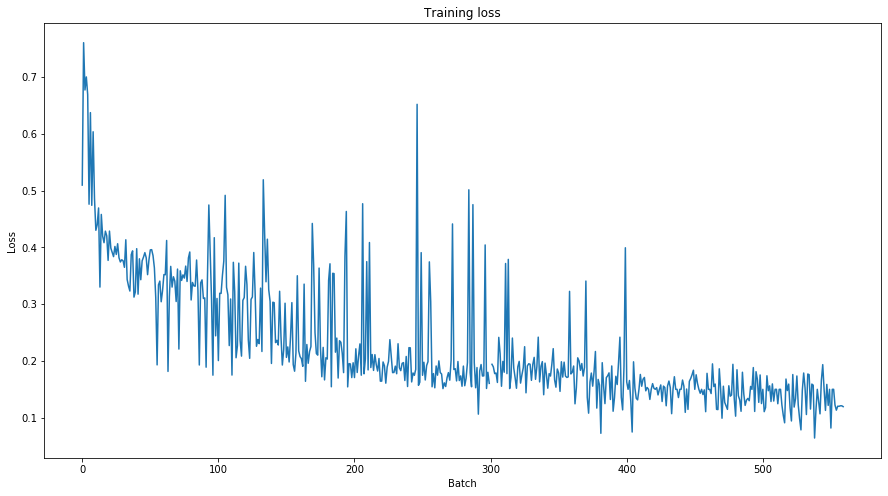

In [28]:
# plot training performance
plt.figure(figsize=(15,8))
plt.title("Training loss")
plt.xlabel("Batch")
plt.ylabel("Loss")
plt.plot(train_loss_set)
plt.show()

In [32]:
# load test data
sentences = ["[CLS] " + query + " [SEP]" for query in query_data_test]
labels = intent_data_label_test

# tokenize test data
tokenized_texts = [tokenizer.tokenize(sent) for sent in sentences]
MAX_LEN = 128
# Pad our input tokens
input_ids = pad_sequences([tokenizer.convert_tokens_to_ids(txt) for txt in tokenized_texts],
                          maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")
# Use the BERT tokenizer to convert the tokens to their index numbers in the BERT vocabulary
input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")
# Create attention masks
attention_masks = []
# Create a mask of 1s for each token followed by 0s for padding
for seq in input_ids:
  seq_mask = [float(i>0) for i in seq]
  attention_masks.append(seq_mask) 

# create test tensors
prediction_inputs = torch.tensor(input_ids)
prediction_masks = torch.tensor(attention_masks)
prediction_labels = torch.tensor(labels)
batch_size = 32  
prediction_data = TensorDataset(prediction_inputs, prediction_masks, prediction_labels)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

## Prediction on test set
# Put model in evaluation mode
model.eval()
# Tracking variables 
predictions , true_labels = [], []
# Predict 
for batch in prediction_dataloader:
  # Add batch to GPU
  batch = tuple(t.to(device) for t in batch)
  # Unpack the inputs from our dataloader
  b_input_ids, b_input_mask, b_labels = batch
  # Telling the model not to compute or store gradients, saving memory and speeding up prediction
  with torch.no_grad():
    # Forward pass, calculate logit predictions
    logits = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
  # Move logits and labels to CPU
  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()  
  # Store predictions and true labels
  predictions.append(logits)
  true_labels.append(label_ids)
  
# Import and evaluate each test batch using Matthew's correlation coefficient
from sklearn.metrics import matthews_corrcoef
matthews_set = []
for i in range(len(true_labels)):
  matthews = matthews_corrcoef(true_labels[i],
                 np.argmax(predictions[i], axis=1).flatten())
  matthews_set.append(matthews)
  
# Flatten the predictions and true values for aggregate Matthew's evaluation on the whole dataset
flat_predictions = [item for sublist in predictions for item in sublist]
flat_predictions = np.argmax(flat_predictions, axis=1).flatten()
flat_true_labels = [item for sublist in true_labels for item in sublist]

print('Classification accuracy using BERT Fine Tuning: {0:0.2%}'.format(matthews_corrcoef(flat_true_labels, flat_predictions)))


Classification accuracy using BERT Fine Tuning: 87.93%


# SCRAP CODE

In [ ]:
# Filtering text based on regex pattern. 
# Pattern is "depression" not followed by "of" and not followed by "region" or "area" in the next 100 characters
depression = discharge.iloc[discharge["TEXT"].apply(lambda x: re.search(r'depression (?!of).{0,100}(?!region)(?!area)', x.lower())).dropna().index].reset_index(drop = True)
print("Number of Patients:", len(depression["SUBJECT_ID"].unique()))